Processing CHIME FRB180916.J0158+65
=====

see CHIME et al. 2020b "Periodic activity from a fast radio burst source"    
This notebook processes the bursts using the data released by CHIME and dedisperses the data further to study how the DM affects the final trend

  0%|          | 0/25 [00:00<?, ?it/s]

Processing with delta dm: -0.5
finding fit 13...
solution nlsq: [200.          80.39068009  64.43463787  12.84824309   1.75426695
   1.56988112]
parameter 1sigma: [8.58940109e+00 7.53421737e-02 5.51793343e-01 5.51793569e-01
 7.53405126e-02 8.45030867e-03]


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\skimage\measure\block.py:87: RuntimeWarning: Mean of empty slice
  **func_kwargs)
B:\dev\sadtrombone\universal\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\universal\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
  8%|▊         | 2/25 [00:00<00:02,  9.09it/s]

finding fit 14...
solution nlsq: [649.31436737  80.37561073  64.41137626   8.4205594   -2.71073736
   2.14313393]
parameter 1sigma: [1.27957182e+01 1.00483914e-01 1.42477301e-01 1.65958581e-01
 5.34279605e-02 1.00101927e-02]


 12%|█▏        | 3/25 [00:00<00:03,  6.37it/s]

finding fit 15...
solution nlsq: [ 97.80701055 140.39083285  64.25220827  11.20626931   5.23765741
   1.85320127]
parameter 1sigma: [0.72209602 0.04371172 0.08018447 0.08273438 0.03866892 0.00624395]
finding fit 15.5...
solution nlsq: [5.06557763e+02 1.76380357e+02 6.43436759e+01 3.42517562e+00
 8.37046718e+00 5.00236871e-01]
parameter 1sigma: [5.39085634 0.05337135 0.08009601 0.03645118 0.08907965 0.00739712]


 16%|█▌        | 4/25 [00:03<00:21,  1.04s/it]

finding fit 16...
solution nlsq: [4.49010463e+02 8.02861983e+01 6.41313615e+01 2.35648090e+00
 4.77379568e+00 2.52044643e-01]
parameter 1sigma: [12.52589345  0.07180323  0.13000313  0.06573795  0.13317297  0.02574871]


 20%|██        | 5/25 [00:04<00:18,  1.07it/s]

finding fit 18...
solution nlsq: [2.68136625e+03 8.04669771e+01 6.44069869e+01 1.36478955e+01
 3.38034400e+00 1.80088606e+00]
parameter 1sigma: [3.51846020e+01 5.94398399e-02 1.74654833e-01 1.79080892e-01
 4.43558347e-02 4.89670205e-03]


 28%|██▊       | 7/25 [00:04<00:13,  1.38it/s]

finding fit 19...
solution nlsq: [1281.0460311    80.37176145   64.32916768    8.27680606    2.74071806
    2.13052953]
parameter 1sigma: [2.45045238e+01 9.50562080e-02 1.36993129e-01 1.58289052e-01
 5.24154200e-02 1.00600444e-02]


 32%|███▏      | 8/25 [00:05<00:11,  1.53it/s]

finding fit 21...
solution nlsq: [311.59487999  80.29090825  64.32880349   8.11497315  -4.21896517
   1.94280515]
parameter 1sigma: [7.04215661 0.11107591 0.17437959 0.1834442  0.09536418 0.02277077]


 40%|████      | 10/25 [00:05<00:08,  1.86it/s]

finding fit 23...
solution nlsq: [4.20340489e+03 8.04800243e+01 6.40285547e+01 1.35075721e+01
 2.11124947e+00 1.73103175e+00]
parameter 1sigma: [5.39224260e+01 3.84605568e-02 1.71113076e-01 1.73278268e-01
 2.70839662e-02 2.90665865e-03]


 48%|████▊     | 12/25 [00:06<00:05,  2.20it/s]

finding fit 24...
solution nlsq: [140.49991463  80.15367591  64.13650276   2.56534394   5.9891523
  72.49867729]
parameter 1sigma: [6.67249365 0.13652076 0.27767978 0.12183097 0.28443135 0.03523175]


 52%|█████▏    | 13/25 [00:07<00:07,  1.65it/s]

finding fit 26...
solution nlsq: [370.45641988  80.21725457  64.00415675   7.09685662   1.12477671
   4.92388763]
parameter 1sigma: [1.05398797e+01 5.26837019e-02 1.97528253e-01 2.01913131e-01
 3.20010958e-02 6.54127138e-03]


 56%|█████▌    | 14/25 [00:08<00:08,  1.28it/s]

finding fit 29...
solution nlsq: [140.96961253  80.34922917  64.11132911   9.12063992   3.66235207
   2.11943299]
parameter 1sigma: [4.34326796 0.17534709 0.24688103 0.28100654 0.11283692 0.02085944]


 68%|██████▊   | 17/25 [00:09<00:04,  1.61it/s]

finding fit 31...
solution nlsq: [200.          58.21155235  64.58933303  11.14046163   1.21371767
   1.60062848]
parameter 1sigma: [9.28792113e+00 5.84150229e-02 5.17133720e-01 5.17361177e-01
 5.63640314e-02 7.24111105e-03]
ere"
finding fit 32...
solution nlsq: [129.88538214  22.42980506  64.29138518  11.73813857   2.9968871
   1.67468583]
parameter 1sigma: [3.1691124  0.07855858 0.28495909 0.28640236 0.07312195 0.00942405]


 76%|███████▌  | 19/25 [00:10<00:03,  1.70it/s]

finding fit 33...
solution nlsq: [828.01345316  80.282555    64.20443201   5.71654295   2.27471653
   1.55537777]
parameter 1sigma: [2.18593876e+01 6.01079883e-02 1.50940490e-01 1.50955621e-01
 6.00699736e-02 1.76544052e-02]


 80%|████████  | 20/25 [00:11<00:03,  1.41it/s]

finding fit 36...
solution nlsq: [ 3.12059938e+03  8.04547542e+01  6.53430572e+01  1.33879079e+01
 -1.52226615e+00  1.50495257e+00]
parameter 1sigma: [4.18903140e+01 2.35702745e-02 1.79329625e-01 1.79713999e-01
 2.04341117e-02 2.18681294e-03]


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


,amplitude,xo,yo,sigmax,sigmay,theta,drift (mhz/ms),angle
13.0,200.000000,80.390680,64.434638,12.848243,1.754267,1.569881,6946.838781,1.569881
14.0,649.314367,80.375611,64.411376,8.420559,-2.710737,2.143134,-9.868245,2.143134
15.0,97.807011,140.390833,64.252208,11.206269,5.237657,1.853201,-21.911463,1.853201
15.5,506.557763,176.380357,64.343676,3.425176,8.370467,0.500237,-11.631378,-1.070559
16.0,449.010463,80.286198,64.131362,2.356481,4.773796,0.252045,-24.688582,-1.318752
18.0,2681.366250,80.466977,64.406987,13.647895,3.380344,1.800886,-27.142600,1.800886
19.0,1281.046031,80.371761,64.329168,8.276806,2.740718,2.130530,-10.146908,2.130530
21.0,311.594880,80.290908,64.328803,8.114973,-4.218965,1.942805,-16.294772,1.942805
23.0,4203.404890,80.480024,64.028555,13.507572,2.111249,1.731032,-39.337882,1.731032
24.0,140.499915,80.153676,64.136503,2.565344,5.989152,72.498677,-25.752021,70.927881


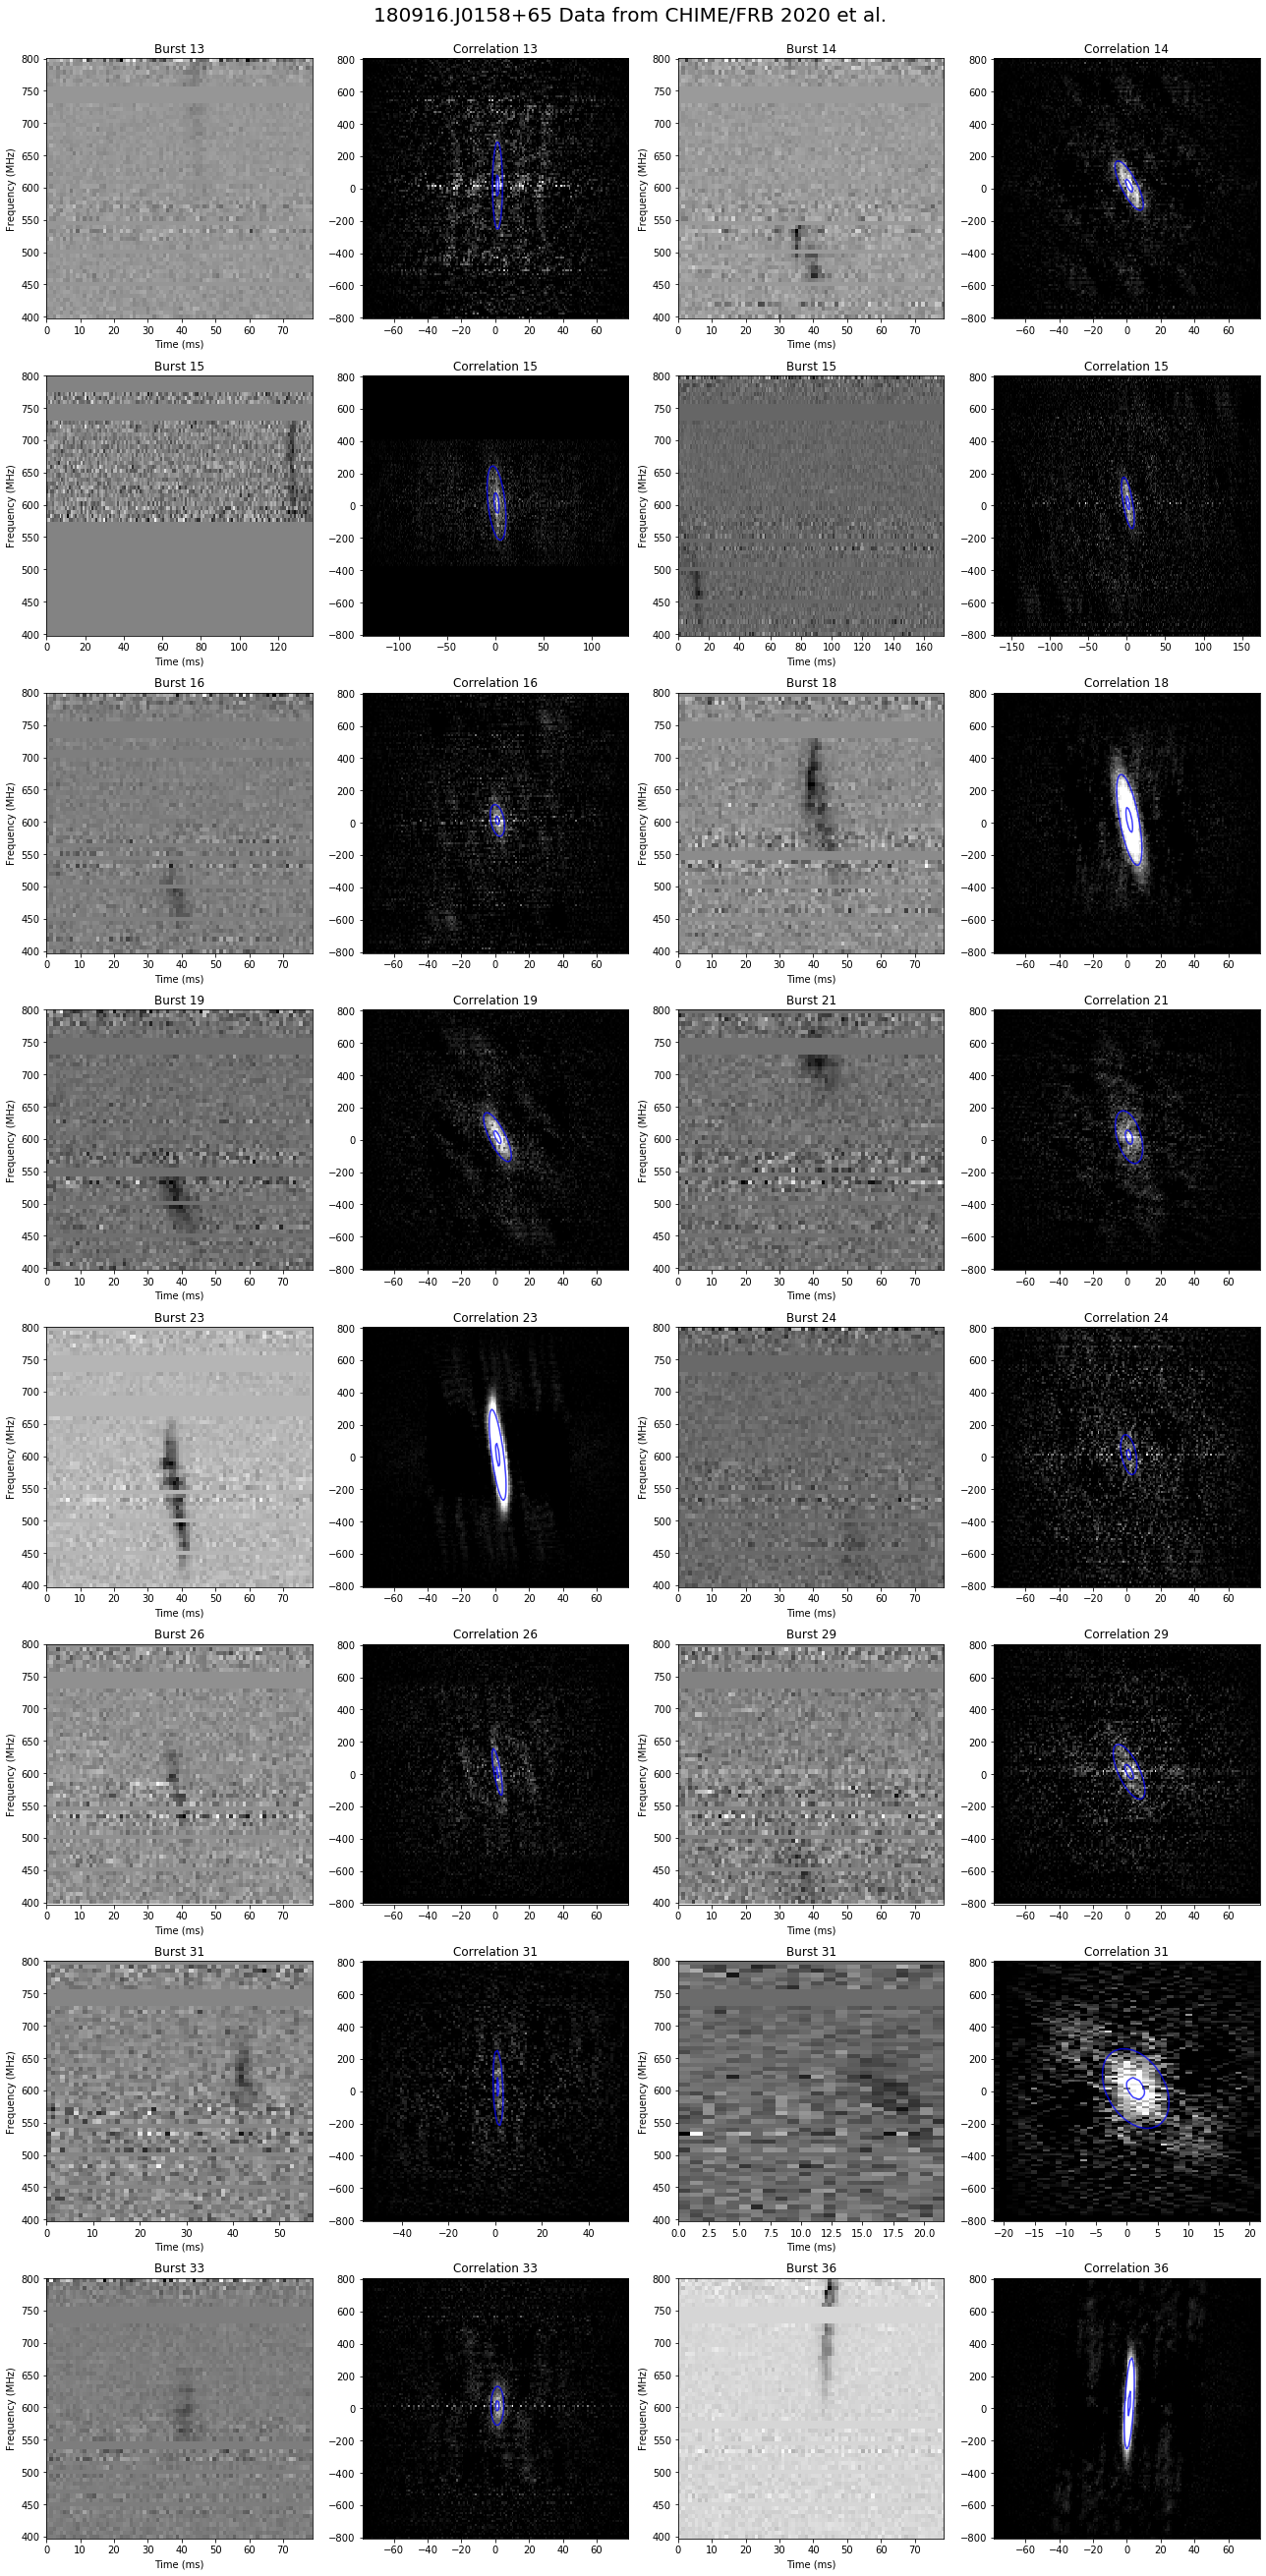

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import os
from tqdm import tqdm
import skimage.measure
import corrfns, fitburst
import itertools

folder = 'data/CHIME_180916.J0158+65'
burstfiles = [s for s in os.listdir(folder) if '16k' in s]
parameterfile = '{}/chime_180916_fit_params_realasf.csv'.format(folder)
errorfile     = '{}/chime_180916_param_errors_realasf.csv'.format(folder)

cmap = plt.get_cmap('gray_r')
cmap.set_bad(color = 'w', alpha = 1.)

if os.path.exists(parameterfile):
    popts = pd.read_csv(parameterfile, index_col=0)
    perrs = pd.read_csv(errorfile, index_col=0)
else:
    popts, perrs = [], []

drifts       = []
drift_errors = []
red_chisqs   = []
angles       = [] # standardize theta to be in [0, pi] 
keys         = []

def dedisperse(intensity, DM, nu_high, chan_width, timestep):
    dedispersed = np.copy(intensity)

    shifts = [0 for i in range(0, len(intensity))]

    for i, row in enumerate(dedispersed):
        nu_low = nu_high - i*chan_width
        deltat = 4.14937759336e6 * (nu_low**-2 - nu_high**-2) * DM
        channelshift = int(round(deltat/timestep))
        dedispersed[i] = np.roll(dedispersed[i], channelshift)

    return dedispersed

def processBurst(burstwindow, burstkey, p0=[], popt_custom=[], bounds=(-np.inf, np.inf), nclip=None, clip=None, ploti=None):
    """
    Given a waterfall of a burst, will use the 2d autocorrelation+gaussian fitting method to find the drift and make a plot of the burst and fit.
    Parameters are added to the global lists above before being saved in a table. Eventually I may want to make this more standalone
    """
    corr = corrfns.auto_corr2D_viafft(burstwindow)
    if nclip != None or clip != None:
        corr = np.clip(corr, nclip, clip)
    #print(burstwindow.shape, corr.shape)
    #### Autocorr noise
    autocorr_sigma = np.std( corr[:, 0:100] )
    # print('autocorr_sigma', autocorr_sigma)
    # auto_sigmas.append(autocorr_sigma)

    #### Fit Gaussian to autocorrelation. Load from parameter file if already found.
    if os.path.exists(parameterfile) and popt_custom == []:
        # print('loading fit...')
        popt, perr = popts.loc[burstkey][:6], perrs.loc[burstkey][:6]
    elif popt_custom != []:
        popt, perr = popt_custom, [-1, -1, -1, -1, -1, -1]
    else:        
        print("finding fit {}...".format(burstkey))
        try:
            popt, pcov = fitburst.fitgaussiannlsq(corr, p0=p0, sigma=autocorr_sigma, bounds=bounds)
            perr = np.sqrt(np.diag(pcov))
            print('solution nlsq:', popt)
            print('parameter 1sigma:', perr)
            #print('pcov diag:', np.diag(pcov))
        except (RuntimeError, ValueError):
            print('no fit found')
            popt, perr = [-1,-1,-1,-1,-1,-1], [-1,-1,-1,-1,-1,-1]
            if popt_custom != []:
                popt = popt_custom
    popts.append(popt)
    perrs.append(perr)

    x, y = np.meshgrid(range(0, corr.shape[1]), range(0, corr.shape[0]))
    #popt[5] = 0.1
    fitmap = fitburst.twoD_Gaussian((y, x), *popt).reshape(corr.shape[0], corr.shape[1])
    
    # calculate reduced chisquared
    residuals = corr - fitmap
    chisq = np.sum((residuals / autocorr_sigma) ** 2)
    red_chisq = chisq / (corr.shape[0]*corr.shape[1] - len(popt)) # this is chisq/(M-N)
    red_chisqs.append(red_chisq)
    # print('reduced chisq:', red_chisq)
    
    # Calculate drifit
    time_res = 0.98304 # ms
    freq_res = 6.25 # MHz
    lowest_freq = 400.20751953125 # MHZ

    theta = popt[5] if abs(popt[3]) > abs(popt[4]) else popt[5] - np.pi/2
    angles.append(theta) #if theta > 0 else angles.append(theta + 2*np.pi)
    slope = np.tan(theta) 
    conversion = freq_res / (time_res)
    drift = conversion * slope # MHz/ms
    theta_err = perr[-1] # do i need to correct this for pixel scale?
    drift_error = conversion * (theta_err * (1/np.cos(theta))**2) 
    
    drifts.append(drift)
    drift_errors.append(drift_error)
    
    #### Plot
    extents = (0, 
               time_res*burstwindow.shape[1],
               lowest_freq - freq_res/2., 
               lowest_freq + freq_res*burstwindow.shape[0])
    
    corrextents = (-extents[1], extents[1], -(extents[3]-extents[2])*2, (extents[3]-extents[2])*2)
    
    if ploti == None:
        plt.figure(figsize=(15, 5))
        plt.subplot(121)
    else:
        plt.subplot(8, 4, next(ploti))
    plt.title("Burst {}".format(burstnum))
    plt.imshow(burstwindow, aspect='auto', cmap=cmap, extent=extents, origin='lower') # white is 0, black is 1
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (MHz)")
    #plt.colorbar()

    if ploti == None:
        plt.subplot(122)
    else:
        plt.subplot(8, 4, next(ploti))
    plt.title("Correlation {}".format(burstnum))
    plt.imshow(corr, aspect='auto', cmap='gray', extent=corrextents, origin='lower')
    plt.clim(0, np.max(corr)/10)
    #plt.colorbar()
    if popt[0] > 0:
        plt.contour(fitmap, [popt[0]/4, popt[0]*0.9], colors='b', alpha=0.75, extent=corrextents, origin='lower')
        
    return drift, drift_error
        
wellfit      = [14, 18, 19, 21, 23, 26, 33, 36]
multiburst   = [15, 24, 31]
exclude      = [12, 17, 20, 22, 27, 28, 30, 34, 35, 37, 38] # too weak, cutoff, or strange morphologies
singleburst  = 13

plt.figure(figsize=(18,36))
plt.suptitle("180916.J0158+65 Data from CHIME/FRB 2020 et al. ", size=20, y=1.01)
ploti = itertools.count(start=1, step=1)
ddm = 1/2
print("Processing with delta dm:", ddm)
for filename in tqdm(burstfiles):
    burstnum = int(filename.split('burst_')[1][:2])
    if burstnum in exclude:
        continue
    
#     if burstnum != singleburst:
#         continue

    data = np.load("{}/{}".format(folder, filename))
    
    wfall = data["wfall"]
    downsample = 256
    wfall_down = skimage.measure.block_reduce(wfall, block_size=(downsample, 1), func=np.nanmean)
    # print(wfall_down.shape, wfall.shape)
    
    dt_s = data["dt_s"]
    center_freq_mhz = data["center_freq_mhz"]
    df_mhz = center_freq_mhz[1] - center_freq_mhz[0]
    # print(dt_s, center_freq_mhz[0], center_freq_mhz[-1], df_mhz)
    
    burstwindow = wfall_down - wfall_down[:, 0:20].mean(axis=1)[:,None]
    burstwindow = np.nan_to_num(wfall_down)
    burstwindow = dedisperse(burstwindow, ddm, 800, 6.25, 0.98304)
    
    ### PROCESS
    # set up initial guesses for problem bursts
    if burstnum == 13:
        if ddm == 0.5:
            p0 = [200, 80.2949248000688, 64.3282045543879, 12.8135786074679, 1.75982726655571, 1.56923145023643]
            bounds = (0, (200, *(np.inf,)*5))
            clip = 3000
        else:
            p0 = [73.331241, 80.394175, 64.434706, 28.821658, 2, 2.352088]
            bounds = (0, (200, *(np.inf,)*5))
            clip = 3000
    elif burstnum == 15:
        p0 = [186.940307, 140.371332, 64.427185, 20, 2, 2.36414]
        bounds = (0, np.inf)
        clip = 5500
    elif burstnum == 16:
        p0 = []
        bounds = (0, np.inf)
        clip = 4000
    elif burstnum == 24:
        if ddm == -2 or ddm == -1:
            p0 = [185.413128462878, 80.1639417218768, 64.0424815070787, 8, 2.68453635647628, 2.1]
            bounds = (0, np.inf)
            clip = 1000
        else:
            p0 = []
            bounds = (0, np.inf)
            clip = 2000
    elif burstnum == 26:
        if ddm == -2 or ddm == -1:
            p0 = [411.048974292209, 80.2175140873591, 63.9702485156176, 12, 1, 2.1]
            bounds = (0, np.inf)
            clip = 3000
        else:
            p0 = []
            bounds = (0, np.inf)
            clip = 3000
    elif burstnum == 29:
        p0 = [175, 80.338841, 64.32839, 13.560142, 2, 2.348835]
        bounds = (0, np.inf)
        clip = 2000
    elif burstnum == 31:
        p0 = [100, 59, 64.11432329, 10, 2, 1.7]
        bounds = (0, (200, *(np.inf,)*5))
        clip = None
    else:
        p0 = []
        bounds = (-np.inf, np.inf)
        clip = None
        
    # split multi bursts
    if burstnum in multiburst:
        if burstnum == 15:
            tsplit = 140
            if ddm == -2 or ddm == -1 or ddm == 0 or ddm == 0.5:
                windowtweaked = np.copy(burstwindow)
                windowtweaked[0:28] = 0
                windowtweaked[60:64] = 0
                processBurst(windowtweaked[:, :tsplit], burstnum, p0=p0, bounds=bounds, ploti=ploti)
            else:
                processBurst(burstwindow[:, :tsplit], burstnum, bounds=bounds, ploti=ploti)
            keys.append(burstnum)
            
            processBurst(burstwindow[:, tsplit+4:], 15.5, bounds=bounds, clip=clip, ploti=ploti)
            keys.append(15.5)
        elif burstnum == 24:
            tsplit = 80
            
            if ddm == -2 or ddm == -1:
                processBurst(burstwindow[:, :tsplit], burstnum, p0=p0, bounds=bounds, clip=clip, ploti=ploti)
            else:
                processBurst(burstwindow[:, :tsplit], burstnum, bounds=bounds, clip=clip, ploti=ploti)
            keys.append(burstnum)
            
            #processBurst(burstwindow[:, tsplit:], burstnum+1, bounds=bounds, clip=clip, ploti=ploti)
            #keys.append(burstnum+1)
        elif burstnum == 31:
            tsplit = 58
            
            processBurst(burstwindow[:, :tsplit], burstnum, bounds=bounds, clip=clip, p0=p0, ploti=ploti)
            keys.append(burstnum)
            
            if ddm == 0.5:
                print('ere"')
                p0_32 = [155.251758447181, 22.4046763407628, 64.3851739155131, 12, 3, 2]
                processBurst(burstwindow[:, tsplit:], burstnum+1, bounds=bounds, p0=p0_32, nclip=0, clip=1000, ploti=ploti)
            else:
                processBurst(burstwindow[:, tsplit:], burstnum+1, ploti=ploti)
            keys.append(burstnum+1)
    else:
        processBurst(burstwindow, burstnum, p0=p0, bounds=bounds, clip=clip, ploti=ploti)
        keys.append(burstnum)
               
    plt.tight_layout()
plt.savefig('bursts180916_ddm-half.png')

select_bursts = keys
if not os.path.exists(parameterfile):
    popts = pd.DataFrame(popts, index=keys, columns=['amplitude', 'xo', 'yo', 'sigmax', 'sigmay', 'theta'])
    perrs = pd.DataFrame(perrs, index=keys, columns=['amp_error', 'xo_error', 'yo_error', 'sigmax_error', 'sigmay_error', 'angle_error'])

    try:
        popts['drift (mhz/ms)']       = drifts
        popts['angle']                = angles
        perrs['drift error (mhz/ms)'] = drift_errors
        perrs['red_chisq']            = red_chisqs

        #popts.to_csv(parameterfile)
        #perrs.to_csv(errorfile)
    except ValueError:
        print('not updating database')
    
    display(popts.loc[select_bursts])
else:
    newparams = pd.DataFrame(popts.loc[select_bursts], index=keys, columns=['amplitude', 'xo', 'yo', 'sigmax', 'sigmay', 'theta', 'drift (mhz/ms)', 'angle'])
    newparams['drift (mhz/ms)']       = drifts
    newparams['angle']                = angles
    display(newparams.loc[select_bursts])


### Baseband data

(64, 900)
(64, 900)
(64, 600)
(64, 900)


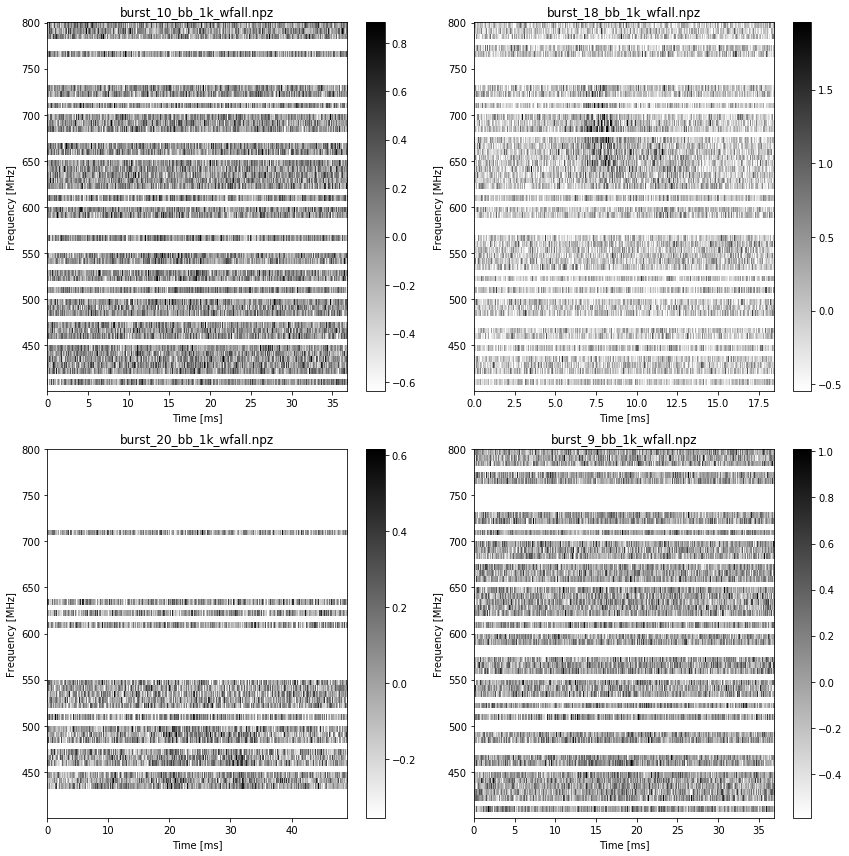

In [2]:
burstfiles = [s for s in os.listdir(folder) if 'bb' in s]

plt.figure(figsize=(12,12))
cmap = plt.get_cmap('gray_r')
cmap.set_bad(color = 'w', alpha = 1.) # potentially hides important errors in the data!

for fname in burstfiles:
    data = np.load("{}/{}".format(folder, fname))
    wfall = data["wfall"]
    wfall_z = np.nan_to_num(wfall)
    
    dt_s = data["dt_s"]
    center_freq_mhz = data["center_freq_mhz"]
    df_mhz = center_freq_mhz[1] - center_freq_mhz[0]
    
    plt.subplot(2,2,burstfiles.index(fname)+1)
 
    bb_downsample = 16
    plt.title(fname)
    plt.imshow(wfall[::16,:], origin="lower", aspect="auto", interpolation="nearest", cmap=cmap,
               extent=(0, 1000*dt_s*wfall.shape[1], center_freq_mhz[0]-df_mhz/2., center_freq_mhz[-1]+df_mhz/2.))
    plt.clim(np.min(wfall_z)*0.5, np.max(wfall_z)*0.5)
    plt.colorbar()
    plt.xlabel("Time [ms]")
    plt.ylabel("Frequency [MHz]")
    print(wfall[::16,:].shape)

plt.tight_layout()